In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import torch.nn.functional as F
import matplotlib.pyplot as plt
from copy import deepcopy

In [48]:

class BaseModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BaseModel, self).__init__()
        seed = torch.randint(0, 1000, (1,)).item()
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        init_weights(self.fc1, seed)
        init_weights(self.fc2, seed)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)
    
class MetaModel(nn.Module):
    def __init__(self, optimizee_in_dim, meta_in_dim=8):
        super(MetaModel, self).__init__()
        self.d = optimizee_in_dim
        self.div = optimizee_in_dim//meta_in_dim
        self.fc1 = nn.Linear(optimizee_in_dim//self.div, meta_in_dim)
        self.fc2 = nn.Linear(meta_in_dim, optimizee_in_dim)
    
    def forward(self, theta_flat):
        outs = []
        if len(theta_flat.shape)==1:
            theta_flat = theta_flat.unsqueeze(0)
        for i in range(0, len(theta_flat), self.d//self.div):
            x = theta_flat[:,i:i+self.d//self.div]
            x = torch.relu(self.fc1(x))
            outs.append(self.fc2(x))
        return torch.cat(outs, dim=0)

    
def init_weights(module, seed=0):
    torch.manual_seed(seed)
    # init weights with xavier 
    # if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
    #     nn.init.xavier_uniform_(module.weight)
    #     nn.init.zeros_(module.bias)

    #print(f"Init weights with seed {seed}")



In [43]:

input_dim = 1
hidden_dim = 32
output_dim = 1
d = sum(p.numel() for p in BaseModel(input_dim, hidden_dim, output_dim).parameters()) +1

n=1000
X = torch.rand(n, input_dim)*4 -2
Y = torch.tanh(X)
# shuffle
perm = torch.randperm(n)
X = X[perm]
Y = Y[perm]
# random split
X_train, X_test = X[:int(n*0.8)], X[int(n*0.8):]
Y_train, Y_test = Y[:int(n*0.8)], Y[int(n*0.8):]


In [44]:
# 1 model
theta_f = BaseModel(input_dim, hidden_dim, output_dim)
meta_model = MetaModel(d)
optimizer = optim.Adam(meta_model.parameters(), lr=1e-2)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

for epoch in range(15):
    optimizer.zero_grad()

    # what if we reinit on each iteration? ie can meta model predict final weights from scratch
    # theta_f = BaseModel(input_dim, hidden_dim, output_dim)  
    
    theta_flat = torch.cat([p.flatten() for p in theta_f.parameters()]).requires_grad_(True)
    theta_flat = torch.cat([theta_flat, torch.tensor([epoch], dtype=torch.float32)]).requires_grad_(True)
    
    theta_flat_prime = meta_model(theta_flat).squeeze(0)
    
    theta_f_prime = BaseModel(input_dim, hidden_dim, output_dim)
    
    params_dict = {}
    start_idx = 0
    for name, param in theta_f_prime.named_parameters():
        param_length = param.numel()
        params_dict[name] = theta_flat_prime[start_idx:start_idx + param_length].view_as(param)
        start_idx += param_length
    
    def modified_forward(x):
        # directly pass the weights into the forward pass. keeps the computation graph intact
        x = F.linear(x, 
                    weight=params_dict['fc1.weight'],
                    bias=params_dict['fc1.bias'])
        x = torch.relu(x)
        x = F.linear(x,
                    weight=params_dict['fc2.weight'],
                    bias=params_dict['fc2.bias'])
        return x
    
    outputs = modified_forward(X_train)
    loss = criterion(outputs, Y_train)
    
    loss.backward()
    
    optimizer.step()
    print(f'Epoch {epoch}, Train Loss {loss.item()}\n')
    
    if epoch == 0:
        make_dot(loss, params=dict(list(meta_model.named_parameters()))).render('comp_graph', format='png')
        

Epoch 0, Train Loss 0.33560967445373535

Epoch 1, Train Loss 0.03629552200436592

Epoch 2, Train Loss 0.09167639911174774

Epoch 3, Train Loss 0.07882853597402573

Epoch 4, Train Loss 0.049331773072481155

Epoch 5, Train Loss 0.038694243878126144

Epoch 6, Train Loss 0.030783681198954582

Epoch 7, Train Loss 0.022609837353229523

Epoch 8, Train Loss 0.019743341952562332

Epoch 9, Train Loss 0.023093603551387787

Epoch 10, Train Loss 0.02837788127362728

Epoch 11, Train Loss 0.030902421101927757

Epoch 12, Train Loss 0.028349943459033966

Epoch 13, Train Loss 0.0214324239641428

Epoch 14, Train Loss 0.013026557862758636



In [5]:
# numel
optimizee_params = sum(p.numel() for p in BaseModel(input_dim, hidden_dim, output_dim).parameters())
meta_model_params = sum(p.numel() for p in meta_model.parameters())

print(f"Optimizee params: {optimizee_params}, Meta model params: {meta_model_params}") # currently meta_model >> optimizee.

Optimizee params: 97, Meta model params: 954


In [6]:
#k models
k = 500
batch_size = 8
optimizees = [BaseModel(input_dim, hidden_dim, output_dim) for _ in range(k)]
meta_model = MetaModel(d).to('cuda')
optimizer = optim.Adam(meta_model.parameters(), lr=1e-2)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
X_train = X_train.to('cuda')
Y_train = Y_train.to('cuda')

for epoch in range(25):
    running_loss = 0.0
    for i in range(0, k, batch_size):
        batch = optimizees[i:i+batch_size]
        batch_flattened = [torch.cat([torch.cat([p.flatten() for p in model.parameters()]), torch.tensor([epoch], dtype=torch.float32)]) for model in batch]
        batch_flattened = torch.stack(batch_flattened).to('cuda')

        optimizer.zero_grad()

        theta_flat_prime = meta_model(batch_flattened)
        
        batch_prime = [BaseModel(input_dim, hidden_dim, output_dim) for _ in range(theta_flat_prime.shape[0])]
        params_dict = {}
        start_idx = 0
        for name, param in batch_prime[0].named_parameters():
            param_length = param.numel() 
            try:
                params_dict[name] = theta_flat_prime[:, start_idx:start_idx + param_length].view(theta_flat_prime.shape[0], *param.shape)
            except:
                print(name, param_length, theta_flat_prime[:, start_idx:start_idx + param_length].shape)
                break
            start_idx += param_length

        def modified_forward(x, idx):
            # directly pass the weights
            x = F.linear(x, 
                        weight=params_dict['fc1.weight'][idx],
                        bias=params_dict['fc1.bias'][idx])
            x = torch.relu(x)
            x = F.linear(x,
                        weight=params_dict['fc2.weight'][idx],
                        bias=params_dict['fc2.bias'][idx])
            return x
        
        
        outputs = [modified_forward(X_train, idx) for idx in range(len(batch_prime))]
        # reassign the outputs to the models
        for i, model in enumerate(optimizees[i:i+batch_size]):
            for name, param in model.named_parameters():
                param.data = params_dict[name][i].cpu()
        loss = torch.stack([criterion(output, Y_train) for output in outputs]).mean()
        loss.backward()
        running_loss += loss.item() * len(batch)
        optimizer.step()
    print(f'Epoch {epoch}, Train Loss {running_loss/len(optimizees)}')
        



Epoch 0, Train Loss 0.06858942236751318
Epoch 1, Train Loss 0.0017153289506677538
Epoch 2, Train Loss 0.00025893434800673275
Epoch 3, Train Loss 0.00012807434413116426
Epoch 4, Train Loss 6.596780658583157e-05
Epoch 5, Train Loss 3.462421795120463e-05
Epoch 6, Train Loss 1.811641452513868e-05
Epoch 7, Train Loss 1.2784575883415528e-05
Epoch 8, Train Loss 1.0806434365804307e-05
Epoch 9, Train Loss 9.764624133822509e-06
Epoch 10, Train Loss 9.182950147078372e-06
Epoch 11, Train Loss 8.798366397968494e-06
Epoch 12, Train Loss 8.537405265087727e-06
Epoch 13, Train Loss 8.326828676217701e-06
Epoch 14, Train Loss 8.125856817059684e-06
Epoch 15, Train Loss 7.922293436422479e-06
Epoch 16, Train Loss 7.73116220079828e-06
Epoch 17, Train Loss 7.545303720689844e-06
Epoch 18, Train Loss 7.347187503910391e-06
Epoch 19, Train Loss 7.130973677703878e-06
Epoch 20, Train Loss 6.944780798221473e-06
Epoch 21, Train Loss 6.7798099116771486e-06
Epoch 22, Train Loss 6.636102585616755e-06
Epoch 23, Train Los

In [27]:
# evaluate overparameterized meta optimizer
k_test = 100
batch_size = 8
optimizees = [BaseModel(input_dim, hidden_dim, output_dim) for _ in range(k_test)]
optimizees_for_adam = [deepcopy(model) for model in optimizees]
meta_model.eval()
X_train = X_train.to('cuda')
Y_train = Y_train.to('cuda')

# initial evaluation on train
initial_losses = [] 
with torch.no_grad():
    for model in optimizees:
        model.to('cuda')
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        initial_losses.append(loss.item())
    print(f'Initial Train Loss {sum(initial_losses)/len(optimizees)}')

epochs = 25
losses_meta = [[] for _ in range(epochs+1)]
losses_meta[0] = initial_losses

for epoch in range(epochs):
    running_loss = 0.0
    for i in range(0, k_test, batch_size):
        batch = optimizees[i:i+batch_size]
        batch_flattened = [torch.cat([torch.cat([p.flatten() for p in model.parameters()]), torch.tensor([epoch], dtype=torch.float32).cuda()]) for model in batch]
        batch_flattened = torch.stack(batch_flattened).to('cuda')

        theta_flat_prime = meta_model(batch_flattened)
        
        batch_prime = [BaseModel(input_dim, hidden_dim, output_dim) for _ in range(theta_flat_prime.shape[0])]
        params_dict = {}
        start_idx = 0
        for name, param in batch_prime[0].named_parameters():
            param_length = param.numel() 
            params_dict[name] = theta_flat_prime[:, start_idx:start_idx + param_length].view(theta_flat_prime.shape[0], *param.shape)
            
            start_idx += param_length

        def modified_forward(x, idx):
            # directly pass the weights
            x = F.linear(x, 
                        weight=params_dict['fc1.weight'][idx],
                        bias=params_dict['fc1.bias'][idx])
            x = torch.relu(x)
            x = F.linear(x,
                        weight=params_dict['fc2.weight'][idx],
                        bias=params_dict['fc2.bias'][idx])
            return x
        
        
        outputs = [modified_forward(X_train, idx) for idx in range(len(batch_prime))]
        # reassign the weights for the next iteration
        for i, model in enumerate(batch):
            for name, param in model.named_parameters():
                param.data = params_dict[name][i].data

        loss = torch.stack([criterion(output, Y_train) for output in outputs])
        losses_meta[epoch+1].extend(loss.clone().detach().flatten().squeeze().cpu().numpy().tolist())
        loss = loss.mean()
        running_loss += loss.item() * len(batch)
    print(f'Epoch {epoch}, eval Train Loss {running_loss/len(optimizees)}')


losses_adam = [[] for _ in range(epochs+1)]
losses_adam[0] = initial_losses
for model in optimizees_for_adam:
    model.to('cuda')
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()
        losses_adam[epoch+1].append(loss.item())
    print(f'Epoch {epoch}, Adam Train Loss {loss.item()}')


Initial Train Loss 0.6034880417585373
Epoch 0, eval Train Loss 0.006960599422454834
Epoch 1, eval Train Loss 0.0004154448735062033
Epoch 2, eval Train Loss 1.87337821625988e-05
Epoch 3, eval Train Loss 6.644122040597722e-06
Epoch 4, eval Train Loss 6.338917337416206e-06
Epoch 5, eval Train Loss 6.329472944344161e-06
Epoch 6, eval Train Loss 6.329170882963809e-06
Epoch 7, eval Train Loss 6.329400330287171e-06
Epoch 8, eval Train Loss 6.329441930574831e-06
Epoch 9, eval Train Loss 6.3294376377598385e-06
Epoch 10, eval Train Loss 6.32943430900923e-06
Epoch 11, eval Train Loss 6.329444113362115e-06
Epoch 12, eval Train Loss 6.329453572107013e-06
Epoch 13, eval Train Loss 6.32945495453896e-06
Epoch 14, eval Train Loss 6.329455736704403e-06
Epoch 15, eval Train Loss 6.329455209197476e-06
Epoch 16, eval Train Loss 6.329455736704403e-06
Epoch 17, eval Train Loss 6.329455209197476e-06
Epoch 18, eval Train Loss 6.329455736704403e-06
Epoch 19, eval Train Loss 6.329455209197476e-06
Epoch 20, eval 

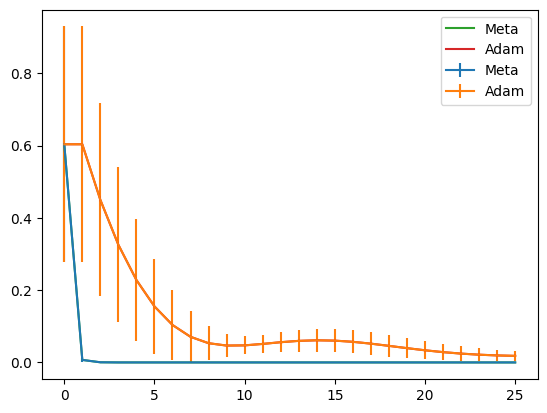

In [28]:
# plto
avg_losses_meta = [sum(losses)/len(losses) for losses in losses_meta]
avg_losses_adam = [sum(losses)/len(losses) for losses in losses_adam]

# error bars
std_losses_meta = [torch.tensor(losses).std().item() for losses in losses_meta]
std_losses_adam = [torch.tensor(losses).std().item() for losses in losses_adam]

plt.errorbar(range(epochs+1), avg_losses_meta, yerr=std_losses_meta, label='Meta')
plt.errorbar(range(epochs+1), avg_losses_adam, yerr=std_losses_adam, label='Adam')


plt.plot(avg_losses_meta, label='Meta')
plt.plot(avg_losses_adam, label='Adam')
plt.legend()
plt.show()

In [93]:
# baseline
model = BaseModel(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
for epoch in range(15):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, Y)
    
    loss.backward()
    
    optimizer.step()
    print(f'Epoch {epoch}, Loss {loss.item()}\n')
    

Epoch 0, Loss 0.32124263048171997

Epoch 1, Loss 0.30983981490135193

Epoch 2, Loss 0.2987545430660248

Epoch 3, Loss 0.28798747062683105

Epoch 4, Loss 0.2775389850139618

Epoch 5, Loss 0.26740792393684387

Epoch 6, Loss 0.25759318470954895

Epoch 7, Loss 0.24809294939041138

Epoch 8, Loss 0.23890462517738342

Epoch 9, Loss 0.23002487421035767

Epoch 10, Loss 0.22144976258277893

Epoch 11, Loss 0.21317480504512787

Epoch 12, Loss 0.20519483089447021

Epoch 13, Loss 0.19750425219535828

Epoch 14, Loss 0.1900968700647354



In [38]:
# import mnist
import torchvision
import torchvision.transforms as transforms
new_mirror = 'https://ossci-datasets.s3.amazonaws.com/mnist'
torchvision.datasets.MNIST.resources = [
   ('/'.join([new_mirror, url.split('/')[-1]]), md5)
   for url, md5 in torchvision.datasets.MNIST.resources
]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./.data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./.data', train=False, download=True, transform=transform)   
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


In [39]:
class MNIST_MLP(nn.Module):
    def __init__(self):
        super(MNIST_MLP, self).__init__()
        self.nn = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return self.nn(x)
    
print("MNIST MLP #params: ", sum(p.numel() for p in MNIST_MLP().parameters()))


MNIST MLP #params:  55050


In [41]:
torch.backends.cudnn.benchmark = True

model = MNIST_MLP().cuda()
# baseline train
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(25):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch}, Loss {running_loss/len(trainloader)}')

Epoch 0, Loss 0.38018541174530984
Epoch 1, Loss 0.1990951547374328
Epoch 2, Loss 0.15067081221863626
Epoch 3, Loss 0.12670108838888505
Epoch 4, Loss 0.11281182187298934
Epoch 5, Loss 0.10083507514055819
Epoch 6, Loss 0.09084022637351105
Epoch 7, Loss 0.0835723392388473
Epoch 8, Loss 0.07622918983983497
Epoch 9, Loss 0.0741366071026617
Epoch 10, Loss 0.06670538113856067
Epoch 11, Loss 0.06394986311641211
Epoch 12, Loss 0.060327415484997135
Epoch 13, Loss 0.05808035696696024
Epoch 14, Loss 0.05397719268865185
Epoch 15, Loss 0.053860319771889285
Epoch 16, Loss 0.05091579967882329
Epoch 17, Loss 0.04807739330239128
Epoch 18, Loss 0.04776675155478976
Epoch 19, Loss 0.043056013567087936
Epoch 20, Loss 0.04395673650925552
Epoch 21, Loss 0.04316002810870802
Epoch 22, Loss 0.03895496913833679
Epoch 23, Loss 0.039845913266538024
Epoch 24, Loss 0.03876570250455164


In [49]:
print("Optimzee # params", sum(p.numel() for p in MNIST_MLP().parameters()))
print("Meta model # params", sum(p.numel() for p in MetaModel(28*28, 28).parameters()))

Optimzee # params 55050
Meta model # params 23548


In [ ]:
k = 500
batch_size = 8
optimizees = [MNIST_MLP() for _ in range(k)]

meta_model = MetaModel(28*28, meta_in_dim=28).to('cuda')
optimizer = optim.Adam(meta_model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

initial_losses = []
with torch.no_grad():
    for model in optimizees:
        model.to('cuda')
        model.eval()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        initial_losses.append(running_loss/len(trainloader))
    print(f'Initial Train Loss {sum(initial_losses)/len(optimizees)}')

epochs = 25
losses_meta = [[] for _ in range(epochs+1)]
losses_meta[0] = initial_losses

for epoch in range(epochs):
    running_loss = 0.0
    for i in range(0, k, batch_size):
        batch = optimizees[i:i+batch_size]
        batch_flattened = [torch.cat([torch.cat([p.flatten() for p in model.parameters()]), torch.tensor([epoch], dtype=torch.float32).cuda()]) for model in batch]
        batch_flattened = torch.stack(batch_flattened).to('cuda')

        theta_flat_prime = meta_model(batch_flattened)
        
        batch_prime = [MNIST_MLP() for _ in range(theta_flat_prime.shape[0])]
        params_dict = {}
        start_idx = 0
        for name, param in batch_prime[0].named_parameters():
            param_length = param.numel() 
            params_dict[name] = theta_flat_prime[:, start_idx:start_idx + param_length].view(theta_flat_prime.shape[0], *param.shape)
            
            start_idx += param_length

        def modified_forward(x, idx):
            # directly pass the weights
            x = F.linear(x, 
                        weight=params_dict['nn.1.weight'][idx],
                        bias=params_dict['nn.1.bias'][idx])
            x = torch.relu(x)
            x = F.linear(x,
                        weight=params_dict['nn.3.weight'][idx],
                        bias=params_dict['nn.3.bias'][idx])
            x = torch.relu(x)
            x = F.linear(x,
                        weight=params_dict['nn.5.weight'][idx],
                        bias=params_dict['nn.5.bias'][idx])
            return x
        
        
        outputs = [modified_forward(inputs, idx) for idx, inputs in enumerate(trainloader)]
        # reassign the weights for the next iteration
        for i, model in enumerate(batch):
            for name, param in model.named_parameters():
                param.data = params_dict[name][i].data

        loss = torch.stack([criterion(output, labels) for output, labels in zip(outputs, trainloader)])
        losses_meta[epoch+1].extend(loss.clone().detach().flatten().squeeze().cpu().numpy().tolist())
        loss = loss.mean()
        running_loss += loss.item() * len(batch)
    print(f'Epoch {epoch}, eval Train Loss {running_loss/len(optimizees)}')


losses_adam = [[] for _ in range(epochs+1)]
losses_adam[0] = initial_losses
for model in optimizees:
    model.to('cuda')
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses_adam[epoch+1].append(running_loss/len(trainloader))
    print(f'Epoch {epoch}, Adam Train Loss {running_loss/len(trainloader)}')
    